# jitcsim tutorial

### Simulation of the Kuramoto model.
The parameter of the model is coupling.
The initial phase also could be changed in repeated simulations.
The output is plotting the time average of the Kuramoto order parameter vs coupling.
This is exampel is run in parallel using multiprocessing.

see also: example : 01, 02 and 03*.py


In [1]:
import numpy as np
from numpy import pi
import networkx as nx
from time import time
from multiprocessing import Pool
from numpy.random import uniform, normal
from jitcsim.visualization import plot_order
from jitcsim.models.kuramoto import Kuramoto_II

In [2]:
np.random.seed(1)

N = 50
num_ensembles = 100
num_processes = 4
alpha0 = 0.0
omega0 = normal(0, 0.1, N)
initial_state = uniform(-pi, pi, N)
adj = nx.to_numpy_array(nx.complete_graph(N))

parameters = {
    'N': N,
    'adj': adj,
    't_initial': 0.,
    "t_final": 100,
    't_transition': 20.0,
    "interval": 1.0,                    # time interval for sampling

    "alpha": alpha0,
    "omega": omega0,
    'initial_state': initial_state,

    'integration_method': 'dopri5',
    'control': ['coupling'],
    "use_omp": False,
    "output": "data",
}

In [3]:
def run_for_each(coupl):

    controls = [coupl]
    I = Kuramoto_II(parameters)
    I.set_initial_state(uniform(-pi, pi, N))
    data = I.simulate(controls)
    x = data['x']
    order = np.mean(I.order_parameter(x))

    return order

In [4]:
# make an instance of the model
sol = Kuramoto_II(parameters)
compile_time = time()
sol.compile()
print("Compile time : {:.3f} secondes.".format(time() - compile_time))

saving file to data/km.so
Compile time : 5.093 secondes.


In [5]:
start_time = time()

# define an array for the strength of couplings
couplings = np.arange(0, 0.8, 0.05) / (N-1)

# prepare parameters for run in parallel
par = []
for i in range(len(couplings)):
    for j in range(num_ensembles):
        par.append(couplings[i])

with Pool(processes=num_processes) as pool:
    orders = (pool.map(run_for_each, par))
orders = np.reshape(orders, (len(couplings), num_ensembles))

print("Simulation time: {:.3f} seconds".format(time()-start_time))


Simulation time: 20.476 seconds


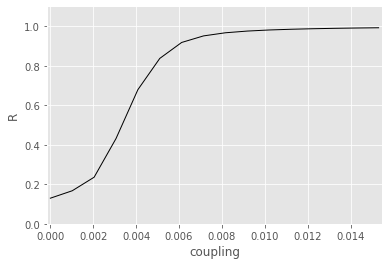

In [6]:
# plotting time average of the order parameters vs coupling
plot_order(couplings,
           np.mean(orders, axis=1),
           filename="data/03.png",
           ylabel="R", 
           xlabel="coupling",
           close_fig=False);